In [ ]:
!pip install pyarrow tensorflow_addons
!pip install --upgrade tensorflow
!pip install pyarrow tensorflow scikit-learn matplotlib seaborn opencv-python pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0


import pyarrow.parquet as pq
import tensorflow as tf
#from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, ResNet152,
    DenseNet121, DenseNet201, EfficientNetB0,
    MobileNetV3Small
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, BackupAndRestore
)
import numpy as np
import pandas as pd
from PIL import Image
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from tensorflow.keras.utils import to_categorical




# -------------------- Mount Google Drive --------------------
from google.colab import drive

# Unmount if already mounted to avoid the error
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        print("Unmounted existing drive.")
    except ValueError:
        pass # Drive was not mounted, no need to unmount

drive.mount('/content/drive')

# -------------------- Load Parquet Dataset --------------------

def load_parquet_dataset(parquet_path, img_size=(224, 224), max_samples=None):
    """
    Load images and labels from .parquet where:
    - 'image' column has dicts with JPEG bytes (key: 'bytes')
    - 'label' column contains 0/1 values
    """
    try:
        df = pq.read_table(parquet_path).to_pandas()
        print("✅ Columns:", df.columns.tolist())
        if max_samples:
            df = df.head(max_samples)

        images, labels = [], []

        for i, row in df.iterrows():
            try:
                image_dict = row['image']
                raw_bytes = image_dict.get('bytes')
                if not isinstance(raw_bytes, (bytes, bytearray)):
                    raise ValueError("Invalid JPEG bytes")

                img = Image.open(io.BytesIO(raw_bytes)).convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(row['label'])
            except Exception as e:
                print(f"⚠️ Row {i} skipped: {e}")

        if not images:
            raise ValueError("❌ No valid images found")

        X = np.array(images) / 255.0  # Normalize
        y = tf.keras.utils.to_categorical(labels, num_classes=2)

        return X, y, labels

    except Exception as e:
        print(f"🚫 Dataset loading failed: {e}")
        return None, None, None



# -------------------- Load Data --------------------
parquet_path = '/content/drive/MyDrive/Research_All/multi_cancer'
X, y, labels = load_parquet_dataset(parquet_path)

if X is None:
    raise SystemExit("❌ Dataset loading failed. Please check .parquet file and format.")

# -------------------- Train/Test Split --------------------
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# -------------------- Model Creator --------------------
def create_model(base_model_class, input_shape=(224, 224, 3), num_classes=2):
    base = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# -------------------- Train Base Models --------------------
base_models = {
    'VGG16': VGG16,
    'VGG19': VGG19,
    'ResNet50': ResNet50,
    'ResNet152': ResNet152,
    'DenseNet121': DenseNet121,
    'DenseNet201': DenseNet201,
    'MobileNetV3': MobileNetV3Small,
    'EfficientNet': EfficientNetB0
}
trained_models = {}

for name, model_class in base_models.items():
    print(f"\n🚀 Training {name}")
    model = create_model(model_class)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    trained_models[name] = model

    # Plot history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.show()


# -------------------- Ensemble Meta Classifier --------------------
def get_meta_features(models, X):
    return np.hstack([model.predict(X) for model in models.values()])

X_meta_train = get_meta_features(trained_models, X_train)
X_meta_val = get_meta_features(trained_models, X_val)

y_train_cls = np.argmax(y_train, axis=1)
y_val_cls = np.argmax(y_val, axis=1)

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_train_cls)


# -------------------- Evaluate Ensemble --------------------
val_preds = meta_model.predict(X_meta_val)
acc = (val_preds == y_val_cls).mean()
print(f"\n✅ Ensemble Accuracy: {acc:.2%}")
print("\n📄 Classification Report:")
print(classification_report(y_val_cls, val_preds))

cm = confusion_matrix(y_val_cls, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# -------------------- Save All Models --------------------a
!mkdir -p saved_models
for name, model in trained_models.items():
    model.save(f'saved_models/{name}.h5')
joblib.dump(meta_model, 'saved_models/meta_model.pkl')
print("✅ All models saved in `saved_models/` directory.")

# Train, Validation, Test

In [ ]:
!pip install -q torch torchvision scikit-learn matplotlib seaborn tqdm pyarrow
!pip install pyarrow pillow torch torchvision tqdm seaborn matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00


Train 80%, Val 20%

In [ ]:
# -------------------- Install Required Packages --------------------
# !pip install pyarrow pillow torch torchvision tqdm seaborn matplotlib scikit-learn

# -------------------- Mount Google Drive --------------------
from google.colab import drive
drive.mount('/content/drive')



# -------------------- Imports --------------------
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------- Config --------------------
GRADE_FILES = [
    #'/content/drive/MyDrive/Research_All/multi_cancer/train-00000-of-00004-40f80292828d4b6c.parquet',
    #'/content/drive/MyDrive/Research_All/multi_cancer/train-00001-of-00004-de395cdb9595cd3b.parquet',
    #'/content/drive/MyDrive/Research_All/multi_cancer/train-00002-of-00004-8b746b230324f3f3.parquet',
    #'/content/drive/MyDrive/Research_All/multi_cancer/train-00003-of-00004-402d3c6cb6e6722a.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled'
]

MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
NUM_EPOCHS = 5
LR = 1e-4
SEED = 42
USE_AMP = True

# -------------------- Set Seed --------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------- Set Device --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

# -------------------- Transforms --------------------
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -------------------- Custom Dataset --------------------
class ParquetDataset(Dataset):
    def __init__(self, parquet_files, labels, tfm=None, max_samples=None):
        self.samples = []
        self.tfm = tfm
        for i, file in enumerate(parquet_files):
            try:
                df = pq.read_table(file).to_pandas()
                print(f"✅ Loaded {file}")
                if max_samples:
                    df = df.head(max_samples)
                for _, row in df.iterrows():
                    img_dict = row['image']
                    img_bytes = img_dict.get('bytes', None)
                    if isinstance(img_bytes, (bytes, bytearray)):
                        self.samples.append((img_bytes, labels[i]))
            except FileNotFoundError:
                print(f"❌ File not found: {file}")
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_bytes, label = self.samples[idx]
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

# -------------------- Create Dataset & Dataloaders --------------------
labels = [2, 3, 4, 5]
full_dataset = ParquetDataset(GRADE_FILES, labels, tfm=train_tfm)

if len(full_dataset) == 0:
    raise SystemExit("❌ No data loaded. Please check file paths and format.")

split_ratio = 0.8
train_size = int(split_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

# -------------------- Model --------------------
num_classes = len(labels)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

# -------------------- Train & Evaluate Functions --------------------
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# -------------------- Training Loop with Auto CPU Fallback --------------------
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_model.pth")

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(epoch)
        val_loss, val_acc = evaluate(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

except RuntimeError as e:
    print("⚠️ Training interrupted. Checking for CUDA error...")
    print(traceback.format_exc())

    if "CUDA" in str(e):
        print("Switching to CPU and resuming training...")
        device = torch.device('cpu')
        amp_enabled = False
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        scaler = torch.amp.GradScaler('cpu', enabled=False)

        for epoch in range(len(history['train_loss']) + 1, NUM_EPOCHS + 1):
            train_loss, train_acc = train_one_epoch(epoch)
            val_loss, val_acc = evaluate(val_loader)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# -------------------- Plot Training Curves --------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(MODELS_DIR, "training_curves.png"))
plt.show()

print(f"✅ Training complete. Best Val Acc: {best_val_acc:.4f}. Model saved to {model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Loaded /content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled
✅ Train samples: 4800, Val samples: 1200


Epoch 1: 100%|██████████| 150/150 [50:44<00:00, 20.30s/it]


Epoch 1: Train Loss 0.1536, Acc 0.9792 | Val Loss 0.0041, Acc 1.0000
✅ Best model saved with Val Acc: 1.0000


Epoch 2:  30%|███       | 45/150 [15:08<34:18, 19.61s/it]

In [ ]:
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')


GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00000-of-00004-40f80292828d4b6c.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00003-of-00004-402d3c6cb6e6722a.parquet',
    # '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled'
]


for file in GRADE_FILES:
    if not os.path.exists(file):
        print(f"❌ File not found: {file}")

total_samples = 0

print("📋 Dataset Overview:\n")

for file in GRADE_FILES:
    df = pd.read_parquet(file)
    num_samples = len(df)
    total_samples += num_samples

    print(f"📂 File: {file.split('/')[-1]}")
    print(f"   ➤ Samples: {num_samples}")
    print(f"   ➤ Columns: {list(df.columns)}\n")

print(f"✅ Total samples across all files: {total_samples}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ File not found: /content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00003-of-00004-402d3c6cb6e6722a.parquet
📋 Dataset Overview:

📂 File: train-00000-of-00004-40f80292828d4b6c.parquet
   ➤ Samples: 1500
   ➤ Columns: ['image', 'organ', 'label']

📂 File: train-00001-of-00004-de395cdb9595cd3b.parquet
   ➤ Samples: 1500
   ➤ Columns: ['image', 'organ', 'label']

📂 File: train-00002-of-00004-8b746b230324f3f3.parquet
   ➤ Samples: 1500
   ➤ Columns: ['image', 'organ', 'label']



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00003-of-00004-402d3c6cb6e6722a.parquet'

In [ ]:
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')

# Original dataset files
GRADE_FILES = [
   # '/content/drive/MyDrive/Research_All/multi_cancer/train-00000-of-00004-40f80292828d4b6c.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/train-00002-of-00004-8b746b230324f3f3.parquet',
   # '/content/drive/MyDrive/Research_All/multi_cancer/train-00003-of-00004-402d3c6cb6e6722a.parquet',
]

# Output directory
OUTPUT_DIR = '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("🔄 Shuffling and reducing to 1500 samples per file...\n")

for file in GRADE_FILES:
    df = pd.read_parquet(file)
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
    reduced_df = df_shuffled.iloc[:1500]  # take first 1500 after shuffle

    filename = os.path.basename(file)
    output_path = os.path.join(OUTPUT_DIR, filename)
    reduced_df.to_parquet(output_path, index=False)

    print(f"✅ Saved: {output_path} — Rows: {len(reduced_df)}")

print("\n🎉 All files shuffled and trimmed to 1500 samples.")


Mounted at /content/drive
🔄 Shuffling and reducing to 1500 samples per file...

✅ Saved: /content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet — Rows: 1500
✅ Saved: /content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet — Rows: 1500

🎉 All files shuffled and trimmed to 1500 samples.


In [ ]:
import pyarrow.parquet as pq
import pandas as pd

# Load the first parquet file
file_path = '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00000-of-00004-40f80292828d4b6c.parquet'
df = pq.read_table(file_path).to_pandas()

# Display basic info
print("DataFrame shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check column names and data types
print("\nColumn info:")
print(df.info())

# Check unique labels (if 'label' column exists)
if 'label' in df.columns:
    print("\nUnique labels:", df['label'].unique())
    print("Label distribution:\n", df['label'].value_counts())

DataFrame shape: (1500, 3)

First 5 rows:


,image,organ,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,1
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,1
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,1



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1500 non-null   object
 1   organ   1500 non-null   int64 
 2   label   1500 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 35.3+ KB
None

Unique labels: [0 1]
Label distribution:
 label
1    1214
0     286
Name: count, dtype: int64


Train 60%, Val 20%, Test 20%

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Loaded /content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled
✅ Train: 3600, Val: 1200, Test: 1200


Epoch 1: 100%|██████████| 113/113 [38:48<00:00, 20.60s/it]


Epoch 1: Train Loss 0.1991, Acc 0.9719 | Val Loss 0.0071, Acc 1.0000
✅ Best model saved with Val Acc: 1.0000


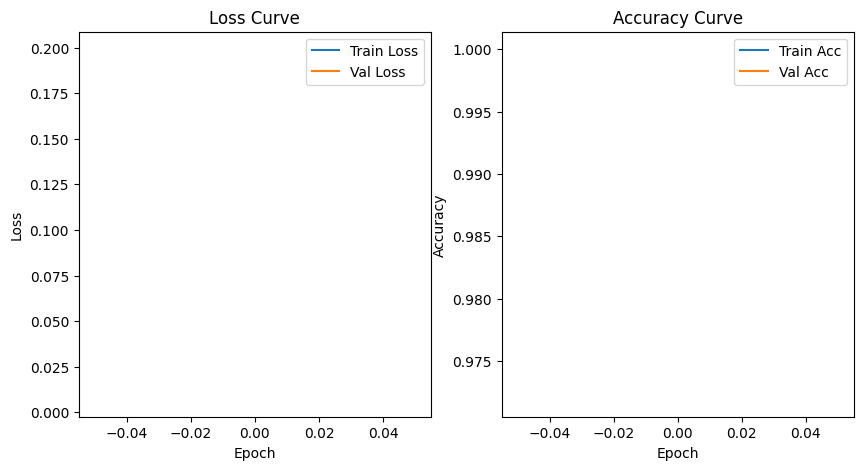

✅ Training complete. Best Val Acc: 1.0000. Model saved to /content/drive/MyDrive/Research_All/multi_cancer/best_model.pth

📊 Test Accuracy: 1.0

📈 Classification Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00      1200

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


📉 Confusion Matrix:
 [[1200]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Config
GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled'
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
NUM_EPOCHS = 1
LR = 1e-4
SEED = 42
USE_AMP = True

# Set Seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

# Transforms
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset
class ParquetDataset(Dataset):
    def __init__(self, parquet_files, labels, tfm=None, max_samples=None):
        self.samples = []
        self.tfm = tfm
        for i, file in enumerate(parquet_files):
            try:
                df = pq.read_table(file).to_pandas()
                print(f"✅ Loaded {file}")
                if max_samples:
                    df = df.head(max_samples)
                for _, row in df.iterrows():
                    img_dict = row['image']
                    img_bytes = img_dict.get('bytes', None)
                    if isinstance(img_bytes, (bytes, bytearray)):
                        self.samples.append((img_bytes, labels[i]))
            except FileNotFoundError:
                print(f"❌ File not found: {file}")
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_bytes, label = self.samples[idx]
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

# Dataset & Split
labels = [2, 3, 4, 5]
full_dataset = ParquetDataset(GRADE_FILES, labels, tfm=train_tfm)
if len(full_dataset) == 0:
    raise SystemExit("❌ No data loaded. Please check file paths and format.")

total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# Model
num_classes = len(labels)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

# Train & Eval
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_model.pth")

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(epoch)
        val_loss, val_acc = evaluate(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

except RuntimeError as e:
    print("⚠️ Training interrupted. Checking for CUDA error...")
    print(traceback.format_exc())
    if "CUDA" in str(e):
        print("Switching to CPU and resuming training...")
        device = torch.device('cpu')
        amp_enabled = False
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        scaler = torch.amp.GradScaler('cpu', enabled=False)

        for epoch in range(len(history['train_loss']) + 1, NUM_EPOCHS + 1):
            train_loss, train_acc = train_one_epoch(epoch)
            val_loss, val_acc = evaluate(val_loader)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(MODELS_DIR, "training_curves.png"))
plt.show()

print(f"✅ Training complete. Best Val Acc: {best_val_acc:.4f}. Model saved to {model_path}")

# Optional Test Evaluation
@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.numpy())
    return y_true, y_pred

y_true, y_pred = test_evaluate(test_loader)
print("\n📊 Test Accuracy:", accuracy_score(y_true, y_pred))
print("\n📈 Classification Report:\n", classification_report(y_true, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))



# Main code with Confusion Matrix

In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Config
GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00000-of-00004-40f80292828d4b6c.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00003-of-00004-402d3c6cb6e6722a.parquet',

]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 64
NUM_EPOCHS = 1
LR = 0.01
SEED = 42
USE_AMP = True

# Set Seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

# Transforms
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset
class ParquetDataset(Dataset):
    def __init__(self, parquet_files, labels, tfm=None, max_samples=None):
        self.samples = []
        self.tfm = tfm
        for i, file in enumerate(parquet_files):
            try:
                df = pq.read_table(file).to_pandas()
                print(f"✅ Loaded {file}")
                if max_samples:
                    df = df.head(max_samples)
                for _, row in df.iterrows():
                    img_dict = row['image']
                    img_bytes = img_dict.get('bytes', None)
                    if isinstance(img_bytes, (bytes, bytearray)):
                        self.samples.append((img_bytes, labels[i]))
            except FileNotFoundError:
                print(f"❌ File not found: {file}")
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_bytes, label = self.samples[idx]
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

# Dataset & Split
labels = [2, 3, 4, 5]
full_dataset = ParquetDataset(GRADE_FILES, labels, tfm=train_tfm)
if len(full_dataset) == 0:
    raise SystemExit("❌ No data loaded. Please check file paths and format.")

total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# Model
num_classes = len(labels)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-4  # L2 regularization
)
scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)


# Train & Eval Functions
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    test_loss = total_loss / len(loader.dataset)
    test_acc = accuracy_score(y_true, y_pred)
    return test_loss, test_acc, y_true, y_pred

# Training Loop
history = {
    'train_loss': [], 'val_loss': [], 'test_loss': [],
    'train_acc': [], 'val_acc': [], 'test_acc': [],
    'all_true': [], 'all_pred': []
}

best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_model.pth")

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        train_loss, train_acc = train_one_epoch(epoch)

        # Validation
        val_loss, val_acc = evaluate(val_loader)

        # Test Evaluation
        test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)
        history['all_true'].extend(y_true)
        history['all_pred'].extend(y_pred)

        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)

        # Print epoch summary
        print(f"\nEpoch {epoch}:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

except RuntimeError as e:
    print("⚠️ Training interrupted. Checking for CUDA error...")
    print(traceback.format_exc())
    if "CUDA" in str(e):
        print("Switching to CPU and resuming training...")
        device = torch.device('cpu')
        amp_enabled = False
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        scaler = torch.amp.GradScaler('cpu', enabled=False)

        for epoch in range(len(history['train_loss']) + 1, NUM_EPOCHS + 1):
            # Training
            train_loss, train_acc = train_one_epoch(epoch)

            # Validation
            val_loss, val_acc = evaluate(val_loader)

            # Test Evaluation
            test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)
            history['all_true'].extend(y_true)
            history['all_pred'].extend(y_pred)

            # Store metrics
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['test_acc'].append(test_acc)

            # Print epoch summary
            print(f"\nEpoch {epoch}:")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
            print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Calculate final metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    history['all_true'], history['all_pred'], average='macro'
)
avg_test_acc = np.mean(history['test_acc'])

# Final Output
print("\n=== Final Model Performance ===")
print(f"Accuracy:    {avg_test_acc:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, "training_curves.png"))
plt.show()

# Classification Report
print("\n=== Detailed Classification Report ===")
print(classification_report(history['all_true'], history['all_pred']))

# Confusion Matrix
cm = confusion_matrix(history['all_true'], history['all_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(MODELS_DIR, "confusion_matrix.png"))
plt.show()

KeyboardInterrupt: 

✅ Loaded: train-00001-of-00004-de395cdb9595cd3b.parquet with labels [0 2]
✅ Loaded: train-00002-of-00004-8b746b230324f3f3.parquet with labels [1 2]

Original class distribution:
label
2    1191
0     917
1     892
Name: count, dtype: int64


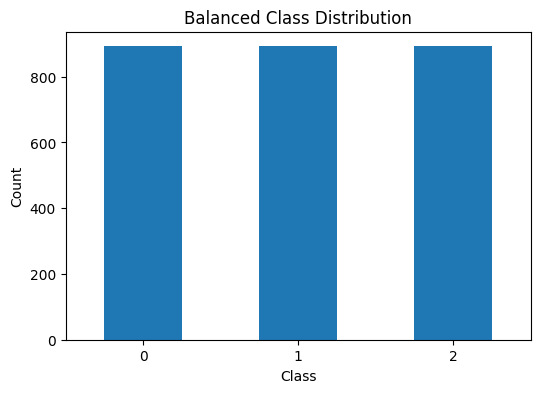


✅ Balanced dataset shape: (2676, 3)

New Balanced class distribution:
label
1    892
2    892
0    892
Name: count, dtype: int64


In [ ]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
]

def load_and_balance_data(parquet_files):
    """Load parquet files, concatenate data, and balance label distribution"""
    df_list = []

    for file in parquet_files:
        try:
            df = pq.read_table(file).to_pandas()
            if 'label' not in df.columns:
                print(f"❌ {file}: No 'label' column found")
                continue
            df_list.append(df)
            print(f"✅ Loaded: {file.split('/')[-1]} with labels {np.unique(df['label'])}")
        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}")

    # Combine all DataFrames
    full_df = pd.concat(df_list, ignore_index=True)

    # Get class counts
    class_counts = full_df['label'].value_counts()
    print("\nOriginal class distribution:")
    print(class_counts)

    # Downsample to the smallest class size
    min_count = class_counts.min()
    balanced_df = pd.DataFrame()

    for label in sorted(full_df['label'].unique()):
        class_df = full_df[full_df['label'] == label]
        class_df_downsampled = resample(class_df,
                                        replace=False,
                                        n_samples=min_count,
                                        random_state=42)
        balanced_df = pd.concat([balanced_df, class_df_downsampled])

    # Shuffle the result
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Plot new class distribution
    plt.figure(figsize=(6, 4))
    balanced_df['label'].value_counts().sort_index().plot(kind='bar')
    plt.title("Balanced Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    print("\n✅ Balanced dataset shape:", balanced_df.shape)
    return balanced_df

# Load and balance
balanced_df = load_and_balance_data(GRADE_FILES)

class_counts = balanced_df['label'].value_counts()
print("\nNew Balanced class distribution:")
print(class_counts)


# Chacking Class Distributions

In [ ]:
import pyarrow.parquet as pq
import numpy as np
from collections import defaultdict

GRADE_FILES = [
    #'/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00000-of-00004-40f80292828d4b6c.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
    #'/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00003-of-00004-402d3c6cb6e6722a.parquet',
]

def get_per_file_distribution(files):
    distributions = []

    for file in files:
        try:
            df = pq.read_table(file).to_pandas()
            counts = np.bincount(df['organ'])
            distributions.append(counts.tolist())
            print(f"{file.split('/')[-1]}: {counts}")
        except Exception as e:
            print(f"Error reading {file}: {e}")
            distributions.append([])

    return distributions

# Get per-file distributions
file_distributions = get_per_file_distribution(GRADE_FILES)
print("\n=== Per-File Distribution ===")
for i, dist in enumerate(file_distributions):
    print(f"File {i+1}: {dist}")

train-00001-of-00004-de395cdb9595cd3b.parquet: [1500]
train-00002-of-00004-8b746b230324f3f3.parquet: [608 892]

=== Per-File Distribution ===
File 1: [1500]
File 2: [608, 892]


# According to Fawzia Mam code

In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Config
GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled'
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
NUM_EPOCHS = 1
LR = 1e-4
SEED = 42
USE_AMP = True

# Set Seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

# Transforms
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset
class ParquetDataset(Dataset):
    def __init__(self, parquet_files, labels, tfm=None, max_samples=None):
        self.samples = []
        self.tfm = tfm
        for i, file in enumerate(parquet_files):
            try:
                df = pq.read_table(file).to_pandas()
                print(f"✅ Loaded {file}")
                if max_samples:
                    df = df.head(max_samples)
                for _, row in df.iterrows():
                    img_dict = row['image']
                    img_bytes = img_dict.get('bytes', None)
                    if isinstance(img_bytes, (bytes, bytearray)):
                        self.samples.append((img_bytes, labels[i]))
            except FileNotFoundError:
                print(f"❌ File not found: {file}")
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_bytes, label = self.samples[idx]
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

# Dataset & Split
labels = [2, 3, 4, 5]
full_dataset = ParquetDataset(GRADE_FILES, labels, tfm=train_tfm)
if len(full_dataset) == 0:
    raise SystemExit("❌ No data loaded. Please check file paths and format.")

total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# Model
num_classes = len(labels)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
    #nn.Linear(in_features=2048, out_features=num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

# Train & Eval
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_model.pth")

try:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(epoch)
        val_loss, val_acc = evaluate(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

except RuntimeError as e:
    print("⚠️ Training interrupted. Checking for CUDA error...")
    print(traceback.format_exc())
    if "CUDA" in str(e):
        print("Switching to CPU and resuming training...")
        device = torch.device('cpu')
        amp_enabled = False
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        scaler = torch.amp.GradScaler('cpu', enabled=False)

        for epoch in range(len(history['train_loss']) + 1, NUM_EPOCHS + 1):
            train_loss, train_acc = train_one_epoch(epoch)
            val_loss, val_acc = evaluate(val_loader)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(MODELS_DIR, "training_curves.png"))
plt.show()

print(f"✅ Training complete. Best Val Acc: {best_val_acc:.4f}. Model saved to {model_path}")

# Optional Test Evaluation
@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.numpy())
    return y_true, y_pred

y_true, y_pred = test_evaluate(test_loader)
print("\n📊 Test Accuracy:", accuracy_score(y_true, y_pred))
print("\n📈 Classification Report:\n", classification_report(y_true, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


# From Kaggle

Dataset download

Train and Validation Path:  /root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1/lung_colon_image_set/Train and Validation Set

Test Path: /root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1/lung_colon_image_set/Test Set

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("javaidahmadwani/lc25000")

print("Path to dataset files:", path)

100%|██████████| 1.76G/1.76G [00:47<00:00, 40.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline



## Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_tree
from xgboost import plot_importance
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn

from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # Inception
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:


w , h= 256,256 # tested with 16 , 32 , 64 , 128 pixel values
final_class = 5
w,h,final_class



(256, 256, 5)

In [ ]:
import os
import pandas as pd

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1/lung_colon_image_set/Train and Validation Set"

# Define class mappings
class_mappings = {
    "colon_aca": "Colon adenocarcinoma",
    "colon_n": "Colon benign tissue",
    "lung_aca": "Lung adenocarcinoma",
    "lung_n": "Lung benign tissue",
    "lung_scc": "Lung squamous cell carcinoma"
}

# Create an empty list to store data
data = []

# Iterate through class folders and load file names
for class_folder, class_name in class_mappings.items():
    class_path = os.path.join(dataset_path, class_folder)
    print(os.path.exists(class_path), class_name)
    if os.path.exists(class_path):  # Check if folder exists
        for image_file in os.listdir(class_path):
            if class_name =='colon_n':
                print(image_file)
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Consider only image files
                image_path = os.path.join(class_path, image_file)
                data.append([image_path, class_name])

# Convert list to DataFrame
df = pd.DataFrame(data, columns=["Image Path", "Class"])

# Save DataFrame to CSV file
csv_filename = "train_validation_images.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully!")

True Colon adenocarcinoma
True Colon benign tissue
True Lung adenocarcinoma
True Lung benign tissue
True Lung squamous cell carcinoma
CSV file 'train_validation_images.csv' created successfully!


In [ ]:


os.listdir('/root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1/lung_colon_image_set/Train and Validation Set')



['colon_n', 'lung_aca', 'colon_aca', 'lung_n', 'lung_scc']

In [ ]:


df.head()



,Image Path,Class
0,/root/.cache/kagglehub/datasets/javaidahmadwan...,Colon adenocarcinoma
1,/root/.cache/kagglehub/datasets/javaidahmadwan...,Colon adenocarcinoma
2,/root/.cache/kagglehub/datasets/javaidahmadwan...,Colon adenocarcinoma
3,/root/.cache/kagglehub/datasets/javaidahmadwan...,Colon adenocarcinoma
4,/root/.cache/kagglehub/datasets/javaidahmadwan...,Colon adenocarcinoma


In [ ]:


df['Class'].unique()



array(['Colon adenocarcinoma', 'Colon benign tissue',
       'Lung adenocarcinoma', 'Lung benign tissue',
       'Lung squamous cell carcinoma'], dtype=object)

In [ ]:
# import pandas as pd
# import random


# # Get unique classes
# unique_classes = df['Class'].unique()

# # Select 2000 images per class
# selected_data = []
# for class_name in unique_classes:
#     class_subset = df[df['Class'] == class_name]  # Filter images of the class
#     selected_images = class_subset.sample(n=2000, random_state=42)  # Randomly select 2000 images
#     selected_data.append(selected_images)

# # Concatenate selected data into a single DataFrame
# df_subset = pd.concat(selected_data, ignore_index=True)

# # Print summary
# print(df_subset['Class'].value_counts())  # Check the count per class
# print(df_subset.head())  # Display first few rows

# # Save to CSV
# df_subset.to_csv('selected_images_2000_per_class.csv', index=False)

In [ ]:


df.shape



(22501, 2)

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm


DIR = '/root/.cache/kagglehub/datasets/javaidahmadwani/lc25000/versions/1/lung_colon_image_set/Train and Validation Set'

# Initialize lists to store data and labels
X = []
Y = []

import os
import cv2
import numpy as np


def load_image(image_id):
    img_path = os.path.join(DIR, image_id)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (w,h))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    else:
        print(image_id, " doest exist ")
        return None
def load_X_Y(df):
    X = []
    Y = []
    for _, row in tqdm(df.iterrows()):
        img = load_image(row['Image Path'])
        if img is not None:
            X.append(img)
            Y.append(row['Class'])
    return np.array(X), np.array(Y)

# Load data
X, Y = load_X_Y(df)


# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Function to preprocess the images
def preprocess_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filtering
    filtered_image = cv2.bilateralFilter(gray_image, d=9, sigmaColor=75, sigmaSpace=75)

    # Normalize the image to range [0, 1]
    normalized_image = filtered_image / 255.0

    # Reshape the image to add a channel dimension
    normalized_image = normalized_image.reshape(normalized_image.shape[0], normalized_image.shape[1], 1)

    return normalized_image

# Preprocess the images
X_preprocessed = []
for i in tqdm(range(X.shape[0]), desc="Preprocessing images"):
    processed_image = preprocess_image(X[i])
    X_preprocessed.append(X[i])

# Convert the list to a numpy array
X_preprocessed = np.array(X_preprocessed)

# Save the preprocessed data and labels as .npy files
np.save('Images.npy', X_preprocessed)
np.save('Labels.npy', Y)

# Print the shapes of the saved arrays
print(f"Processed image dataset shape: {X_preprocessed.shape}")
print(f"Labels shape: {Y.shape}")

NameError: name 'df' is not defined

In [ ]:


X = X_preprocessed



In [ ]:
y = Y


In [ ]:


y




In [ ]:


from sklearn.preprocessing import OneHotEncoder
Y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y = enc.transform(Y).toarray()
Y.shape



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=42, test_size=0.1)
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))


## FSPAN - Y Block

The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP. It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.


In [ ]:
(w, h, c) = X.shape[1], X.shape[2], X.shape[3]
(w, h, c)


In [ ]:


final_class



In [ ]:
import tensorflow
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D, Dense, Dropout, Input, Conv2D, multiply, Lambda, BatchNormalization, Concatenate, ReLU, Add, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

def create_novel_feature_extractor(input_shape=(64, 64, 3), final_class=5):
    in_lay = Input(shape=input_shape)

    # Load VGG16 as base model (without top layers)
    base_pretrained_model = tensorflow.keras.applications.ConvNeXtTiny(input_shape=input_shape, include_top=False, weights='imagenet')
    base_pretrained_model.trainable = False
    pt_features = base_pretrained_model(in_lay)

    # Apply Batch Normalization
    bn_features  = Conv2D(512, (1, 1), padding='same', activation='relu')(pt_features)
    bn_features = BatchNormalization()(bn_features)

    # Attention mechanism
    attn_layer = Conv2D(64, (1, 1), padding='same', activation='relu')(bn_features)
    attn_layer = Conv2D(16, (1, 1), padding='same', activation='relu')(attn_layer)
    attn_layer = Conv2D(1, (1, 1), padding='valid', activation='sigmoid')(attn_layer)

    up_c2 = Conv2D(bn_features.shape[-1], (1, 1), padding='same', activation='linear', use_bias=False)(attn_layer)
    up_c2 = Dropout(0.25)(up_c2)



    # T-block module
    def Y_Block(x, filters, dilation_rate=2, name="Y_Block"):
        conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu', name=f'{name}_conv1')(x)
        conv2 = Conv2D(filters, (3, 3), dilation_rate=dilation_rate, padding='same', activation='relu', name=f'{name}_conv2')(x)
        concat = Concatenate(name=f'{name}_concat')([conv1, conv2])
        out = BatchNormalization(name=f'{name}_bn')(concat)
        out = Dropout(0.25)(out)
        return ReLU(name=f'{name}_relu')(out)



    # Feature Summarised Pyramidial Attention network
    def FSPAN(x, name):
        avg_pool = GlobalAveragePooling2D(name=f'{name}_avgpool')(x)
        max_pool = GlobalMaxPooling2D(name=f'{name}_maxpool')(x)
        dense_avg = Dense(x.shape[-1], activation='relu', name=f'{name}_dense_avg')(avg_pool)
        dense_avg = Dropout(0.25)(dense_avg)
        dense_max = Dense(x.shape[-1], activation='relu', name=f'{name}_dense_max')(max_pool)
        dense_max = Dropout(0.25)(dense_max)
        semantic_attention = Add(name=f'{name}_semantic_add')([dense_avg, dense_max])
        semantic_attention = Activation('sigmoid', name=f'{name}_semantic_sigmoid')(semantic_attention)
        semantic_attention = Lambda(lambda x: K.expand_dims(K.expand_dims(x, 1), 1))(semantic_attention)
        semantic_out = multiply([x, semantic_attention])
        scale1 = Conv2D(x.shape[-1], (1, 1), padding='same', name=f'{name}_scale1')(x)
        scale2 = Conv2D(x.shape[-1], (3, 3), padding='same', dilation_rate=2, name=f'{name}_scale2')(x)
        scale3 = Conv2D(x.shape[-1], (5, 5), padding='same', dilation_rate=3, name=f'{name}_scale3')(x)
        multi_scale_context = Concatenate(name=f'{name}_concat')([scale1, scale2, scale3])
        multi_scale_context = Dense(512, activation='relu', name=f'{name}_dense_IMA')(avg_pool)
        return multi_scale_context

    t_features = Y_Block(bn_features, filters=64, name="Y_Block1")
    ima_features1 = FSPAN(t_features, name="IMA1")
    t_features = Y_Block(t_features, filters=128, name="Y_Block2")
    ima_features2 = FSPAN(t_features, name="IMA2")
    t_features = Y_Block(t_features, filters=256, name="Y_Block3")

    mask_features1 = multiply([up_c2, bn_features])

    mask_features2 = multiply([t_features, mask_features1]) # T block Effect on Features
    gap_features = GlobalAveragePooling2D()(mask_features2)
    gap_mask = GlobalAveragePooling2D()(attn_layer)

    mask_features3 = multiply([ima_features1, ima_features2]) # IMA 1 and 2
    gap_features_IMA1 = Dense(512)(mask_features3)
    gap_features_IMA1 = Dropout(0.25)(gap_features_IMA1)


    gap = Lambda(lambda x: x[0] / (x[1] + K.epsilon()), name='RescaleGAP')([gap_features, gap_mask, gap_features_IMA1 ])
    dr_steps = Dropout(0.25)(Dense(128, activation='elu')(gap))
    out_layer = Dense(final_class, activation='softmax')(dr_steps)

    # Create and compile model
    model = Model(inputs=[in_lay], outputs=[out_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Example usage
novel_model = create_novel_feature_extractor(input_shape=(w, h, c), final_class= final_class)
novel_model.summary()

In [ ]:


Model: "functional_4"



In [ ]:


import tensorflow as tf
tf.keras.utils.plot_model(
    novel_model,
    show_shapes=False,
    show_layer_names=True
)



In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.weights.h5".format('mammo_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
 # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint,  reduceLROnPlat]
history = novel_model.fit(X_train, y_train,  validation_data = (X_test, y_test),
                                  epochs = 20,
                                  callbacks = callbacks_list)

In [ ]:




# load the best version of the model
novel_model.load_weights(weight_path)






## Show Attention

Did our attention model learn anything useful?


In [ ]:


mammo_model = novel_model



In [ ]:


mammo_model.summary()



In [ ]:


Model: "functional_4"



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Load the image dataset from the .npy file
image_array = np.load("/kaggle/working/Images.npy")  # Shape: (num_images, height, width, channels)
labels  = np.load("/kaggle/working/Labels.npy")

# Select a random image
import random

# Select 5 unique random indices from the valid range
random_indices = random.sample(range(len(image_array)), 5)

print(random_indices)  # Output: List of 5 unique indices


for i in random_indices:
    img = image_array[i]
    # Resize if necessary (assuming model input is 256x256)
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # Normalize and add batch dimension
    img_resized = np.expand_dims(img_resized / 255.0, axis=0)

    # Load trained model
    model = novel_model

    # Choose attention layers
    attention_layers = ["conv2d","Y_Block1_relu","Y_Block2_relu", "Y_Block3_relu", "multiply_3"]
    _
    # Create a sub-model to extract attention maps
    layer_outputs = [model.get_layer(layer).output for layer in attention_layers]
    attention_model = Model(inputs=model.input, outputs=layer_outputs)

    # Get attention maps for the randomly selected image
    attention_maps = attention_model.predict(img_resized)

    # Create subplots for visualization
    fig, axs = plt.subplots(1, len(attention_layers) + 1, figsize=(18, 6))

    # Show original image
    axs[0].imshow(img)
    axs[0].set_title("Original Image", fontsize=14, fontweight="bold")
    axs[0].axis("off")

    # Display attention maps
    for i, (att_map, layer_name) in enumerate(zip(attention_maps, attention_layers)):
        att_map = np.mean(att_map[0], axis=-1)  # Average across channels
        att_map = cv2.resize(att_map, (256, 256), interpolation=cv2.INTER_CUBIC)

        # Overlay heatmap
        axs[i + 1].imshow(img)
        axs[i + 1].imshow(att_map, cmap="jet", alpha=0.4)
        axs[i + 1].set_title(f"Attention: {layer_name}", fontsize=12, fontweight="bold")
        axs[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Randomly selected image index: {i}")


## GRAD CAM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import random

# Load the image dataset from the .npy file
image_array = np.load("/kaggle/working/Images.npy")  # Shape: (num_images, height, width, channels)
labels = np.load("/kaggle/working/Labels.npy")

# Load the pre-trained model
model = novel_model

# Select 5 unique random indices
random_indices = random.sample(range(len(image_array)), 20)
print("Selected indices:", random_indices)

# Define Grad-CAM function
def grad_cam(model, image, layer_name):
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)  # Convert image to tensor
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image_tensor)  # Ensure TensorFlow operations
        predictions = predictions[0][0]  # Extract tensor from the list
        #print(predictions)
        class_idx = int(np.argmax(predictions))  # Ensure a scalar integer
        #print(class_idx)
        loss = predictions[class_idx]  # Compute loss

    grads = tape.gradient(loss, conv_output)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    heatmap = tf.maximum(heatmap, 0)  # ReLU to keep only positive values
    heatmap /= tf.reduce_max(heatmap)  # Normalize heatmap

    return heatmap.numpy()  # Convert back to NumPy for visualization




# Define target layers for different components
layers = {
    "Y-Block1": "Y_Block1_conv2",
    "Y-Block2": "Y_Block2_conv2",
    "Y-Block3": "Y_Block3_conv2",

    "FSPAN": "multiply_2"

}

# Create subplots: (Rows: Images, Columns: Components)


for i, idx in enumerate(random_indices):
    image = image_array[idx]
    label = labels[idx]

    fig, axes = plt.subplots(1, len(layers) + 1, figsize=(15, 20))
    # Display original image
    axes[ 0].imshow(image)
    axes[ 0].set_title(f"Original - Label: {label}")
    axes[0].axis("off")

    for j, (comp_name, layer) in enumerate(layers.items()):
        heatmap = grad_cam(model, image, layer)
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        image = np.uint8(255 * image) if image.dtype != np.uint8 else image  # Convert to uint8 if needed
        superimposed_image = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)


        # Plot Grad-CAM for each layer
        axes[ j + 1].imshow(superimposed_image)
        axes[ j + 1].set_title(comp_name)
        axes[ j + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Extract training history data
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Create a figure with 2 subplots: one for loss and one for accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Loss
axs[0].plot(epochs_range, loss, label='Training Loss', color='b', marker='o', linestyle='-', linewidth=2)
axs[0].plot(epochs_range, val_loss, label='Validation Loss', color='r', marker='o', linestyle='--', linewidth=2)
axs[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plotting Accuracy
axs[1].plot(epochs_range, acc, label='Training Accuracy', color='b', marker='o', linestyle='-', linewidth=2)
axs[1].plot(epochs_range, val_acc, label='Validation Accuracy', color='r', marker='o', linestyle='--', linewidth=2)
axs[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

# Make sure to bold the ticks and gridlines
for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('training_loss_accuracy.png', dpi=300)
plt.show()

## Evaluate the results¶

In [ ]:
pred_Y = mammo_model.predict(X_test, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
y_test = np.argmax(y_test,-1)
test_Y_cat = y_test



In [ ]:


print("Unique classes in test_Y_cat:", len(np.unique(test_Y_cat)))
print("Unique classes in pred_Y_cat:", len(np.unique(pred_Y_cat)))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, cohen_kappa_score

# Assuming test_Y_cat and pred_Y_cat are your true labels and predictions
labels = np.unique(test_Y_cat)

# Compute confusion matrix
cm = confusion_matrix(test_Y_cat, pred_Y_cat)

# Plot confusion matrix with numbers
plt.figure(figsize=(8, 6))
plt.matshow(cm, cmap='Blues', fignum=1)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add numbers to confusion matrix
for (i, j), value in np.ndenumerate(cm):
    plt.text(j, i, f'{value}', ha='center', va='center', color='white' if value > cm.max()/2 else 'black')

plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.show()

# Print classification report
print(classification_report(test_Y_cat, pred_Y_cat, labels=labels))

# Function to calculate additional metrics
def calculate_metrics(test_y, pred_y):
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    specificity_dict = {}
    sensitivity_dict = {}

    for avg in ['micro', 'macro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(test_y, pred_y, average=avg)

        # Calculate specificity and sensitivity for each class
        for label in np.unique(test_y):
            TN = cm.sum() - (cm[:, label].sum() + cm[label, :].sum() - cm[label, label])
            FP = cm[:, label].sum() - cm[label, label]
            TP = cm[label, label]
            FN = cm[label, :].sum() - cm[label, label]

            specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
            sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

            specificity_dict[label] = specificity
            sensitivity_dict[label] = sensitivity

        # Store metrics in dictionaries
        precision_dict[avg] = precision
        recall_dict[avg] = recall
        f1_dict[avg] = f1

    return precision_dict, recall_dict, f1_dict, specificity_dict, sensitivity_dict

# Get predicted probabilities
pred_probs = mammo_model.predict(X_test)  # Make sure to replace 'model' with your actual model variable

# Calculate metrics
precision_dict, recall_dict, f1_dict, specificity_dict, sensitivity_dict = calculate_metrics(test_Y_cat, pred_Y_cat)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Micro': [
        precision_dict['micro'],
        recall_dict['micro'],
        f1_dict['micro']
    ],
    'Macro': [
        precision_dict['macro'],
        recall_dict['macro'],
        f1_dict['macro']
    ],
    'Weighted': [
        precision_dict['weighted'],
        recall_dict['weighted'],
        f1_dict['weighted']

    ]
})

# Calculate specificity and sensitivity for each label
for label in np.unique(test_Y_cat):
    summary_df.loc[summary_df['Metric'] == 'Specificity', 'Micro'] = specificity_dict[label] if 'micro' in specificity_dict else np.nan
    summary_df.loc[summary_df['Metric'] == 'Sensitivity', 'Micro'] = sensitivity_dict[label] if 'micro' in sensitivity_dict else np.nan



# Explanation of averaging methods
print("\nDifferences between averaging methods:")
print("- Micro Average: Calculates metrics globally by counting the total true positives, false negatives, and false positives. It is useful when you want to evaluate the overall performance.")
print("- Macro Average: Calculates metrics for each class separately and then takes the average. It treats all classes equally and is useful when you want to give equal weight to all classes.")
print("- Weighted Average: Similar to macro average, but it takes the class imbalance into account by weighing the metrics of each class by its size. It is useful when you want to balance performance across classes.")

In [ ]:


summary_df



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Global DataFrame to store results (shared with machine learning models)
crdf = pd.DataFrame()

def visualise(y_true, y_pred, name, model_name):
    ConfusionM = confusion_matrix(y_true, y_pred)

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=name, digits=4))
    print()

    # Plot confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(ConfusionM / ConfusionM.astype(float).sum(axis=0),
                annot=True, fmt='0.2f', cmap='Greys',
                xticklabels=name, yticklabels=name)
    plt.title('Confusion Matrix for ' + model_name)
    plt.savefig('CM_' + model_name + '.jpg')
    plt.show()

    # Calculate various metrics
    accuracy = accuracy_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    jaccard_sim = jaccard_score(y_true, y_pred, average='macro')

    # Append results to global DataFrame
    global crdf
    temp_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Cohen\'s Kappa': [cohen_kappa],
        'Jaccard Similarity': [jaccard_sim]
    })

    # Append classification metrics for each class (Precision, Recall, F1-Score)
    report = classification_report(y_true, y_pred, target_names=name, output_dict=True)
    for label in name:
        temp_df[f'{label}_Precision'] = report[label]['precision']
        temp_df[f'{label}_Recall'] = report[label]['recall']
        temp_df[f'{label}_F1-Score'] = report[label]['f1-score']

    crdf = pd.concat([crdf, temp_df], ignore_index=True)

# Example prediction function for deep learning model
def pred(X, Y):
    yhat = mammo_model.predict(X)
    yhat = enc.inverse_transform(yhat)
    y_real = enc.inverse_transform(Y)
    return y_real, yhat

# Example usage for the deep learning model
yt, yp = pred(X, Y)  # Replace 'xop' and 'Y' with your actual test data and labels

visualise(yt, yp, list(enc.categories_[0]) , 'FSPAN Infused YBlock Network')  # 'ANN' for Artificial Neural Network or any other model name

# The `crdf` DataFrame will now include results from both ML and DL models.
crdf

In [ ]:


list(enc.categories_[0])



# All Model Correct Code

## Using LSTM model Correct Code


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Train: 1605, Val: 535, Test: 536


Epoch 1: 100%|██████████| 51/51 [06:18<00:00,  7.42s/it]



Epoch 1:
Train Loss: 1.0416 | Train Acc: 0.4692
Val Loss:   0.9423 | Val Acc:   0.5794
Test Loss:  0.9325 | Test Acc:  0.5672
✅ Best model saved with Val Acc: 0.5794


Epoch 2: 100%|██████████| 51/51 [06:24<00:00,  7.54s/it]



Epoch 2:
Train Loss: 0.8897 | Train Acc: 0.5221
Val Loss:   0.6355 | Val Acc:   0.6729
Test Loss:  0.6404 | Test Acc:  0.6567
✅ Best model saved with Val Acc: 0.6729


Epoch 3: 100%|██████████| 51/51 [06:08<00:00,  7.22s/it]



Epoch 3:
Train Loss: 0.9562 | Train Acc: 0.4941
Val Loss:   1.0454 | Val Acc:   0.5364
Test Loss:  1.0252 | Test Acc:  0.5392


Epoch 4: 100%|██████████| 51/51 [06:22<00:00,  7.49s/it]



Epoch 4:
Train Loss: 0.9269 | Train Acc: 0.4953
Val Loss:   0.6236 | Val Acc:   0.7477
Test Loss:  0.6207 | Test Acc:  0.7388
✅ Best model saved with Val Acc: 0.7477


Epoch 5: 100%|██████████| 51/51 [07:10<00:00,  8.44s/it]



Epoch 5:
Train Loss: 0.7367 | Train Acc: 0.5944
Val Loss:   0.6027 | Val Acc:   0.6879
Test Loss:  0.5938 | Test Acc:  0.6754


Epoch 6: 100%|██████████| 51/51 [07:01<00:00,  8.27s/it]



Epoch 6:
Train Loss: 0.6684 | Train Acc: 0.6143
Val Loss:   0.5432 | Val Acc:   0.6411
Test Loss:  0.5496 | Test Acc:  0.6418


Epoch 7: 100%|██████████| 51/51 [06:59<00:00,  8.23s/it]



Epoch 7:
Train Loss: 0.7072 | Train Acc: 0.5751
Val Loss:   0.5529 | Val Acc:   0.6748
Test Loss:  0.5476 | Test Acc:  0.6604


Epoch 8: 100%|██████████| 51/51 [06:55<00:00,  8.14s/it]



Epoch 8:
Train Loss: 0.7206 | Train Acc: 0.6012
Val Loss:   0.6504 | Val Acc:   0.6766
Test Loss:  0.6468 | Test Acc:  0.6754


Epoch 9: 100%|██████████| 51/51 [06:36<00:00,  7.77s/it]



Epoch 9:
Train Loss: 0.7524 | Train Acc: 0.5452
Val Loss:   0.5964 | Val Acc:   0.6187
Test Loss:  0.5697 | Test Acc:  0.6362


Epoch 10: 100%|██████████| 51/51 [06:12<00:00,  7.30s/it]



Epoch 10:
Train Loss: 0.8248 | Train Acc: 0.5526
Val Loss:   0.7751 | Val Acc:   0.5458
Test Loss:  0.7541 | Test Acc:  0.5597

=== Final Model Performance ===
Accuracy:    0.6351
Precision:   0.6415
Recall:      0.6350
F1 Score:    0.6316


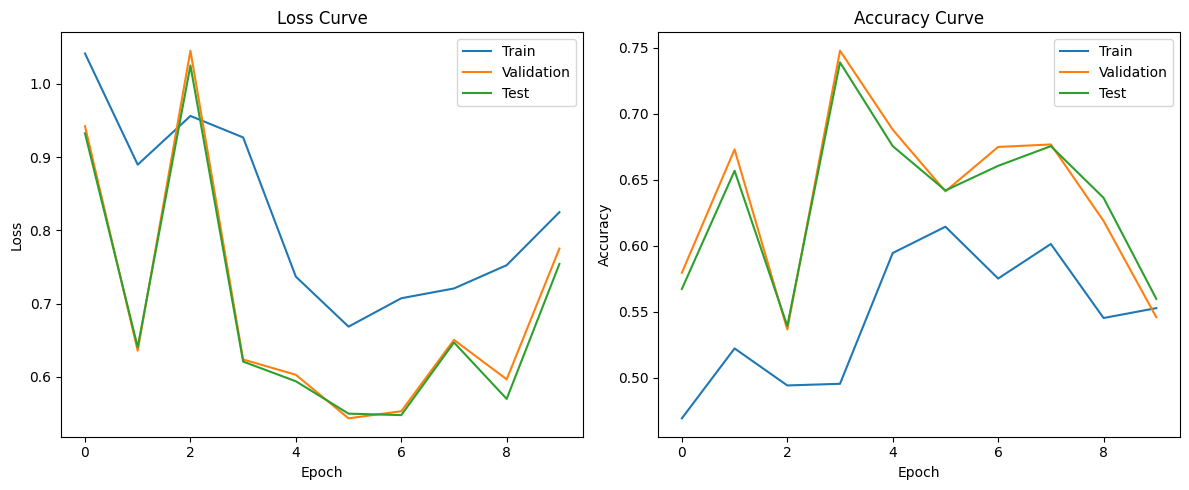

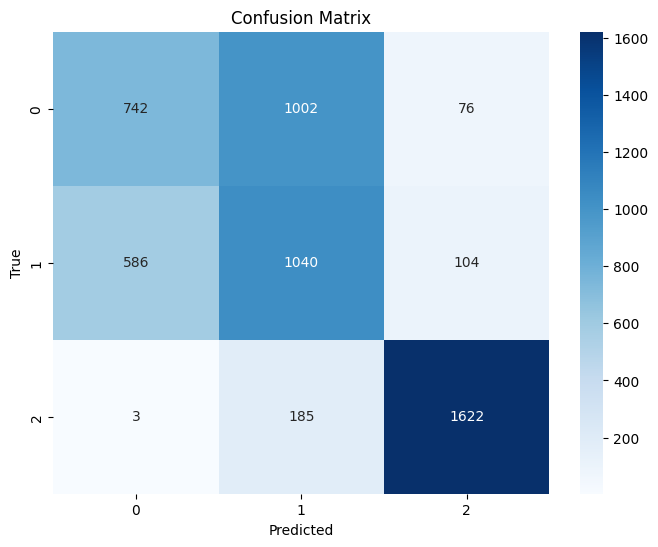


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.41      0.47      1820
           1       0.47      0.60      0.53      1730
           2       0.90      0.90      0.90      1810

    accuracy                           0.64      5360
   macro avg       0.64      0.63      0.63      5360
weighted avg       0.64      0.64      0.63      5360



In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 0.001
SEED = 42
USE_AMP = True

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# LSTM Model Definition
class CancerLSTM(nn.Module):
    def __init__(self, input_size=224*224*3, hidden_size=256, num_layers=2, num_classes=4):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten image and add sequence dimension
        x = self.flatten(x).unsqueeze(1)  # [batch, 1, 224*224*3]

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Only take the last output
        out = self.fc(lstm_out[:, -1, :])
        return out





# Data Loading and Balancing
def load_balanced_df(files):
    dfs = [pq.read_table(f).to_pandas() for f in files]
    df = pd.concat(dfs)
    df = df[df['label'].notnull()]
    min_class_size = df['label'].value_counts().min()
    balanced_dfs = [resample(df[df['label'] == c],
                           replace=False,
                           n_samples=min_class_size,
                           random_state=SEED)
                   for c in df['label'].unique()]
    return pd.concat(balanced_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)

balanced_df = load_balanced_df(GRADE_FILES)

class BalancedParquetDataset(Dataset):
    def __init__(self, dataframe, tfm=None):
        self.df = dataframe
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bytes = row['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, int(row['label'])

# Dataset Preparation
full_dataset = BalancedParquetDataset(balanced_df, tfm=train_tfm)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# Model Initialization
num_classes = balanced_df['label'].nunique()
model = CancerLSTM(
    input_size=224*224*3,
    hidden_size=256,
    num_layers=2,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scaler = torch.amp.GradScaler(enabled=amp_enabled)

# EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_acc, model, path):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(model, path)
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(model, path)
            self.counter = 0

    def save_checkpoint(self, model, path):
        torch.save(model.state_dict(), path)
        if self.verbose:
            print(f"✅ Model checkpoint saved at {path}")


# Training Functions
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if amp_enabled:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(y_true, y_pred), y_true, y_pred

# Training Loop
history = {
    'train_loss': [], 'val_loss': [], 'test_loss': [],
    'train_acc': [], 'val_acc': [], 'test_acc': [],
    'all_true': [], 'all_pred': []
}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_lstm_model.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    history['all_true'].extend(y_true)
    history['all_pred'].extend(y_pred)

    print(f"\nEpoch {epoch}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Evaluation
precision, recall, f1, _ = precision_recall_fscore_support(
    history['all_true'], history['all_pred'], average='macro'
)

print("\n=== Final Model Performance ===")
print(f"Accuracy:    {np.mean(history['test_acc']):.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, "lstm_training_curves.png"))
plt.show()

# Confusion Matrix
cm = confusion_matrix(history['all_true'], history['all_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(MODELS_DIR, "lstm_confusion_matrix.png"))
plt.show()

print("\n=== Classification Report ===")
print(classification_report(history['all_true'], history['all_pred']))




## BiLSTM Modified Version

In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
GRADE_FILES = [
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Research_All/multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 0.0005
SEED = 42
USE_AMP = True

# Set seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

# Enhanced Data Augmentation
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Enhanced BiLSTM Model with CNN features
class CancerBiLSTM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # CNN feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=128*28*28,  # After 3 maxpool layers (224/8=28)
            hidden_size=256,
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),  # 256*2 for bidirectional
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # CNN features
        x = self.features(x)
        batch_size = x.size(0)
        x = x.view(batch_size, 1, -1)  # [batch, 1, 128*28*28]

        # BiLSTM
        lstm_out, _ = self.bilstm(x)

        # Classifier
        out = self.classifier(lstm_out[:, -1, :])
        return out

# Data loading functions
def load_balanced_df(files):
    dfs = [pq.read_table(f).to_pandas() for f in files]
    df = pd.concat(dfs)
    df = df[df['label'].notnull()]
    min_class_size = df['label'].value_counts().min()
    balanced_dfs = [resample(df[df['label'] == c],
                           replace=False,
                           n_samples=min_class_size,
                           random_state=SEED)
                   for c in df['label'].unique()]
    return pd.concat(balanced_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)

class BalancedParquetDataset(Dataset):
    def __init__(self, dataframe, tfm=None):
        self.df = dataframe
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bytes = row['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, int(row['label'])

# Load and split data
balanced_df = load_balanced_df(GRADE_FILES)
full_dataset = BalancedParquetDataset(balanced_df, tfm=train_tfm)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
print("Class distribution:", np.bincount([y for _, y in train_ds]))

# Initialize model
num_classes = balanced_df['label'].nunique()
model = CancerBiLSTM(num_classes=num_classes).to(device)

# Enhanced training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Training functions with gradient clipping
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(y_true, y_pred), y_true, y_pred

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
           'train_acc': [], 'val_acc': [], 'test_acc': [],
           'all_true': [], 'all_pred': []}
best_val_acc = 0.0
patience = 5
no_improvement = 0
model_path = os.path.join(MODELS_DIR, "best_bilstm_model.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)

    # Update learning rate
    scheduler.step(val_acc)

    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    history['all_true'].extend(y_true)
    history['all_pred'].extend(y_pred)

    print(f"\nEpoch {epoch}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement = 0
        torch.save(model.state_dict(), model_path)
        print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

# Final evaluation
precision, recall, f1, _ = precision_recall_fscore_support(
    history['all_true'], history['all_pred'], average='macro'
)

print("\n=== Final Model Performance ===")
print(f"Accuracy:    {np.mean(history['test_acc']):.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, "training_curves.png"))
plt.show()

# Confusion Matrix
cm = confusion_matrix(history['all_true'], history['all_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(MODELS_DIR, "confusion_matrix.png"))
plt.show()

print("\n=== Classification Report ===")
print(classification_report(history['all_true'], history['all_pred']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Train: 1605, Val: 535, Test: 536
Class distribution: [533 553 519]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1: 100%|██████████| 26/26 [12:18<00:00, 28.41s/it]



Epoch 1:
Train Loss: 0.7461 | Train Acc: 0.7333
Val Loss:   0.9940 | Val Acc:   0.8617
Test Loss:  0.9961 | Test Acc:  0.8563
Current LR: 5.00e-04
✅ Best model saved with Val Acc: 0.8617


Epoch 2: 100%|██████████| 26/26 [11:09<00:00, 25.75s/it]



Epoch 2:
Train Loss: 0.4630 | Train Acc: 0.9333
Val Loss:   0.5527 | Val Acc:   0.9327
Test Loss:  0.5285 | Test Acc:  0.9608
Current LR: 5.00e-04
✅ Best model saved with Val Acc: 0.9327


Epoch 3: 100%|██████████| 26/26 [11:24<00:00, 26.31s/it]



Epoch 3:
Train Loss: 0.4406 | Train Acc: 0.9389
Val Loss:   0.3631 | Val Acc:   0.9626
Test Loss:  0.3633 | Test Acc:  0.9646
Current LR: 5.00e-04
✅ Best model saved with Val Acc: 0.9626


Epoch 4:   4%|▍         | 1/26 [00:37<15:26, 37.05s/it]

## ResNet50 Final Coreect Code


In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
GRADE_FILES = [
    '/content/drive/MyDrive/DUET/LungAndColonCancer/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/DUET/LungAndColonCancer/train-00002-of-00004-8b746b230324f3f3.parquet',
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 0.001
SEED = 42
USE_AMP = True

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Loading and Balancing (limit to 3000 samples)
def load_balanced_df(files, total_samples=2676):
    dfs = [pq.read_table(f).to_pandas() for f in files]
    df = pd.concat(dfs)
    df = df[df['label'].notnull()]
    min_class_size = df['label'].value_counts().min()
    balanced_dfs = [resample(df[df['label'] == c],
                              replace=False,
                              n_samples=min_class_size,
                              random_state=SEED)
                    for c in df['label'].unique()]
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)
    return balanced_df.sample(n=total_samples, random_state=SEED).reset_index(drop=True)

# ⚠️ Limit to exactly 2676 samples
balanced_df = load_balanced_df(GRADE_FILES, total_samples=2676)

class BalancedParquetDataset(Dataset):
    def __init__(self, dataframe, tfm=None):
        self.df = dataframe
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bytes = row['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, int(row['label'])

# Dataset Preparation
full_dataset = BalancedParquetDataset(balanced_df, tfm=train_tfm)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# ✅ Model Initialization: ResNet50 with best practice
num_classes = balanced_df['label'].nunique()
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# ✅ Best practice optimizer for ResNet50 fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scaler = torch.amp.GradScaler(enabled=amp_enabled)

# EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_acc, model, path):
        if self.best_score is None:
            self.best_score = val_acc
            self.save_checkpoint(model, path)
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.save_checkpoint(model, path)
            self.counter = 0

    def save_checkpoint(self, model, path):
        torch.save(model.state_dict(), path)
        if self.verbose:
            print(f"✅ Model checkpoint saved at {path}")

# Training Functions
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if amp_enabled:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(y_true, y_pred), y_true, y_pred

# Training Loop
history = {
    'train_loss': [], 'val_loss': [], 'test_loss': [],
    'train_acc': [], 'val_acc': [], 'test_acc': [],
    'all_true': [], 'all_pred': []
}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_resnet50_model.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    history['all_true'].extend(y_true)
    history['all_pred'].extend(y_pred)

    print(f"\nEpoch {epoch}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Evaluation
precision, recall, f1, _ = precision_recall_fscore_support(
    history['all_true'], history['all_pred'], average='macro'
)

print("\n=== Final Model Performance ===")
print(f"Accuracy:    {np.mean(history['test_acc']):.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, "resnet50_training_curves.png"))
plt.show()

# Confusion Matrix
cm = confusion_matrix(history['all_true'], history['all_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(MODELS_DIR, "resnet50_confusion_matrix.png"))
plt.show()

print("\n=== Classification Report ===")
print(classification_report(history['all_true'], history['all_pred']))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Train: 1605, Val: 535, Test: 536


Epoch 1:  75%|███████▍  | 38/51 [17:03<05:50, 26.94s/it]


KeyboardInterrupt: 

## EfficientNet-B0 Code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu, AMP: False
✅ Train: 1605, Val: 535, Test: 536


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.1MB/s]
Epoch 1: 100%|██████████| 101/101 [06:15<00:00,  3.72s/it]



Epoch 1:
Train Loss: 0.1660 | Train Acc: 0.9439
Val Loss:   0.0117 | Val Acc:   0.9981
Test Loss:  0.0066 | Test Acc:  1.0000
✅ Best model saved with Val Acc: 0.9981


Epoch 2: 100%|██████████| 101/101 [06:06<00:00,  3.63s/it]



Epoch 2:
Train Loss: 0.1026 | Train Acc: 0.9688
Val Loss:   0.0085 | Val Acc:   0.9981
Test Loss:  0.0031 | Test Acc:  1.0000


Epoch 3: 100%|██████████| 101/101 [06:12<00:00,  3.69s/it]



Epoch 3:
Train Loss: 0.0688 | Train Acc: 0.9794
Val Loss:   0.0060 | Val Acc:   1.0000
Test Loss:  0.0073 | Test Acc:  1.0000
✅ Best model saved with Val Acc: 1.0000


Epoch 4: 100%|██████████| 101/101 [06:14<00:00,  3.71s/it]



Epoch 4:
Train Loss: 0.0493 | Train Acc: 0.9907
Val Loss:   0.0063 | Val Acc:   0.9981
Test Loss:  0.0036 | Test Acc:  1.0000


Epoch 5: 100%|██████████| 101/101 [06:10<00:00,  3.67s/it]



Epoch 5:
Train Loss: 0.0203 | Train Acc: 0.9944
Val Loss:   0.0026 | Val Acc:   1.0000
Test Loss:  0.0114 | Test Acc:  0.9963


Epoch 6: 100%|██████████| 101/101 [06:15<00:00,  3.72s/it]



Epoch 6:
Train Loss: 0.0525 | Train Acc: 0.9875
Val Loss:   0.0105 | Val Acc:   0.9981
Test Loss:  0.0039 | Test Acc:  1.0000


Epoch 7: 100%|██████████| 101/101 [06:08<00:00,  3.65s/it]



Epoch 7:
Train Loss: 0.0106 | Train Acc: 0.9981
Val Loss:   0.0010 | Val Acc:   1.0000
Test Loss:  0.0078 | Test Acc:  0.9963


Epoch 8: 100%|██████████| 101/101 [06:13<00:00,  3.70s/it]



Epoch 8:
Train Loss: 0.0235 | Train Acc: 0.9931
Val Loss:   0.0166 | Val Acc:   0.9963
Test Loss:  0.0152 | Test Acc:  0.9963


Epoch 9: 100%|██████████| 101/101 [06:12<00:00,  3.69s/it]



Epoch 9:
Train Loss: 0.1360 | Train Acc: 0.9688
Val Loss:   0.0007 | Val Acc:   1.0000
Test Loss:  0.0041 | Test Acc:  0.9963


Epoch 10: 100%|██████████| 101/101 [06:10<00:00,  3.66s/it]



Epoch 10:
Train Loss: 0.0067 | Train Acc: 0.9988
Val Loss:   0.0007 | Val Acc:   1.0000
Test Loss:  0.0004 | Test Acc:  1.0000

=== Final Model Performance ===
Accuracy:    0.9985
Precision:   0.9985
Recall:      0.9985
F1 Score:    0.9985


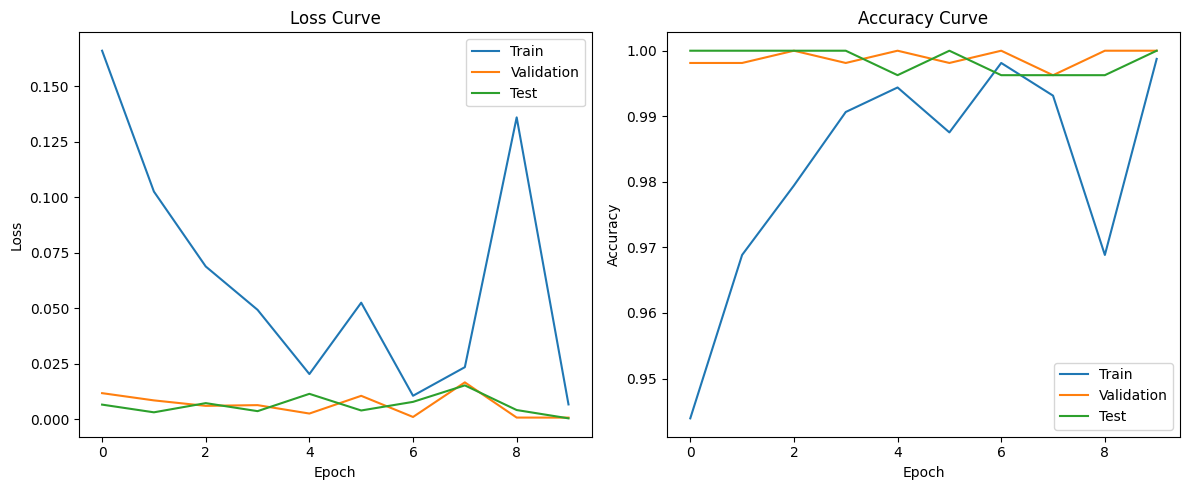

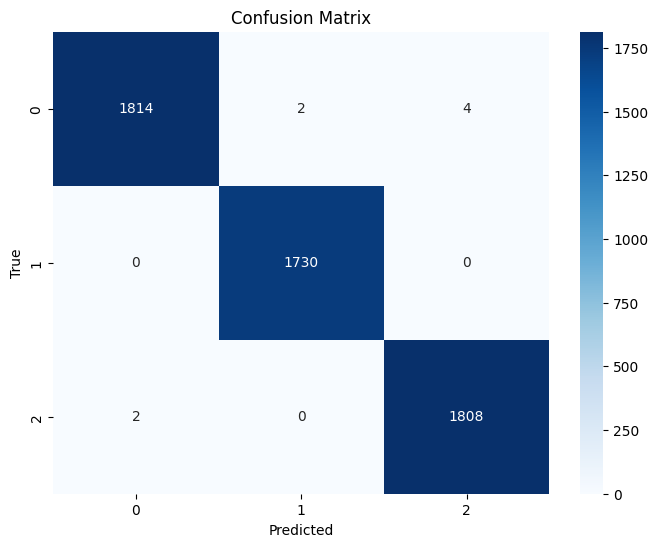


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       1.00      1.00      1.00      1730
           2       1.00      1.00      1.00      1810

    accuracy                           1.00      5360
   macro avg       1.00      1.00      1.00      5360
weighted avg       1.00      1.00      1.00      5360



In [ ]:
import os
import io
import random
import traceback
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import resample

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
GRADE_FILES = [
    '/content/drive/MyDrive/Multi_cancer/reduced_1500_shuffled/train-00001-of-00004-de395cdb9595cd3b.parquet',
    '/content/drive/MyDrive/Multi_cancer/reduced_1500_shuffled/train-00002-of-00004-8b746b230324f3f3.parquet',
]
MODELS_DIR = '/content/drive/MyDrive/Research_All/multi_cancer'
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 16
NUM_EPOCHS = 10
LR = 0.001
SEED = 42
USE_AMP = True

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amp_enabled = (device.type == 'cuda') and USE_AMP
print(f"✅ Using device: {device}, AMP: {amp_enabled}")

train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_balanced_df(files):
    dfs = [pq.read_table(f).to_pandas() for f in files]
    df = pd.concat(dfs)
    df = df[df['label'].notnull()]
    min_class_size = df['label'].value_counts().min()
    balanced_dfs = [resample(df[df['label'] == c], replace=False, n_samples=min_class_size, random_state=SEED) for c in df['label'].unique()]
    return pd.concat(balanced_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)

balanced_df = load_balanced_df(GRADE_FILES)

class BalancedParquetDataset(Dataset):
    def __init__(self, dataframe, tfm=None):
        self.df = dataframe
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bytes = row['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, int(row['label'])

# Split data
full_dataset = BalancedParquetDataset(balanced_df, tfm=train_tfm)
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# ✅ EfficientNet Model Setup
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

num_classes = balanced_df['label'].nunique()
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = torch.amp.GradScaler(enabled=amp_enabled)

# Training/Eval Functions
def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), total_correct / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

@torch.no_grad()
def test_evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(y_true, y_pred), y_true, y_pred

# Training Loop
history = {'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': [], 'all_true': [], 'all_pred': []}
best_val_acc = 0.0
model_path = os.path.join(MODELS_DIR, "best_model_balanced.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc, y_true, y_pred = test_evaluate(test_loader)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    history['all_true'].extend(y_true)
    history['all_pred'].extend(y_pred)

    print(f"\nEpoch {epoch}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"✅ Best model saved with Val Acc: {best_val_acc:.4f}")

# Final Metrics
precision, recall, f1, _ = precision_recall_fscore_support(history['all_true'], history['all_pred'], average='macro')

print("\n=== Final Model Performance ===")
print(f"Accuracy:    {np.mean(history['test_acc']):.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")

# Plot Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, "training_curves_balanced.png"))
plt.show()

# Confusion Matrix
cm = confusion_matrix(history['all_true'], history['all_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(MODELS_DIR, "confusion_matrix_balanced.png"))
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(history['all_true'], history['all_pred']))
